In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

In [10]:
from urllib.request import urlretrieve
import os

if not os.path.exists('secom.data'):
    print("Downloading SECOM dataset...")
    urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data', 'secom.data')
    urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data', 'secom_labels.data')

data = pd.read_csv('secom.data', sep='\s+', header=None)
labels = pd.read_csv('secom_labels.data', sep='\s+', header=None)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

constant_mask = data.nunique() == 1
constant_cols = data.columns[constant_mask]
print(f"Constant columns to remove: {len(constant_cols)}")

if len(constant_cols) > 0:
    data = data.drop(columns=constant_cols)

print(f"Shape after removal: {data.shape}")

print(f"NaN values before imputation: {data.isna().sum().sum()}")
data = data.apply(lambda x: x.fillna(x.median()), axis=0)
print(f"NaN values after imputation: {data.isna().sum().sum()}")

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

print(f"Final data shape: {data_scaled.shape}")
print(f"Data range - Min: {data_scaled.min().min():.4f}, Max: {data_scaled.max().max():.4f}")

Data shape: (1567, 590)
Labels shape: (1567, 2)
Constant columns to remove: 116
Shape after removal: (1567, 474)
NaN values before imputation: 41136
NaN values after imputation: 0
Final data shape: (1567, 474)
Data range - Min: -37.9235, Max: 39.5727


In [16]:
X = data_scaled
y = labels.iloc[:, 0]

start_time = time.time()

mi_scores = mutual_info_classif(X, y, random_state=42)
top_20_mi_idx = np.argsort(mi_scores)[-20:][::-1]
top_20_mi_features = X.columns[top_20_mi_idx].tolist()

mi_time = time.time() - start_time
print(f"Top 20 MI features selected in {mi_time:.2f} seconds")
print(f"MI scores range: {mi_scores.min():.4f} to {mi_scores.max():.4f}")

# start_time = time.time()

# estimator = RandomForestClassifier(n_estimators=100, random_state=42)
# rfe = RFE(estimator=estimator, n_features_to_select=20)
# rfe.fit(X, y)

# rfe_time = time.time() - start_time
# top_20_rfe_features = X.columns[rfe.support_].tolist()

# print(f"RFE completed in {rfe_time:.2f} seconds")
# print(f"Selected {len(top_20_rfe_features)} features")

Top 20 MI features selected in 2.37 seconds
MI scores range: 0.0000 to 0.0281


In [17]:
# Stop current execution and run this instead with different configuration

start_time = time.time()

estimator = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42)
rfe = RFE(estimator=estimator, n_features_to_select=20, step=5)
rfe.fit(X, y)

rfe_time = time.time() - start_time
top_20_rfe_features = X.columns[rfe.support_].tolist()

print(f"Fast RFE completed in {rfe_time:.2f} seconds")
print(f"Selected {len(top_20_rfe_features)} features")

Fast RFE completed in 27.98 seconds
Selected 20 features


In [19]:
U, Sigma, Vt = np.linalg.svd(data_scaled, full_matrices=False)

In [22]:
def feature_scores_svd_normalized(Vt, Sigma, k=20):
    k = min(k, len(Sigma))
    Vt_k = Vt[:k, :]
    Sigma_k = Sigma[:k]
    
    Sigma_norm = Sigma_k / Sigma_k.sum()
    
    scores = np.sum((Sigma_norm[:, np.newaxis]) * np.abs(Vt_k), axis=0)
    
    return scores

svd_scores_norm = feature_scores_svd_normalized(Vt, Sigma, k=20)
top_20_svd_idx_norm = np.argsort(svd_scores_norm)[-20:][::-1]
top_20_svd_features_norm = data_scaled.columns[top_20_svd_idx_norm].tolist()

print(f"Normalized SVD scores range: {svd_scores_norm.min():.6f} to {svd_scores_norm.max():.6f}")
print(f"\nTop 5 features with normalized scores:")
for i in range(5):
    print(f"  Feature {top_20_svd_features_norm[i]}: {svd_scores_norm[top_20_svd_idx_norm[i]]:.6f}")

Normalized SVD scores range: 0.006444 to 0.052291

Top 5 features with normalized scores:
  Feature 303: 0.052291
  Feature 168: 0.051149
  Feature 556: 0.048934
  Feature 550: 0.048922
  Feature 132: 0.048786


Creating loading plot...


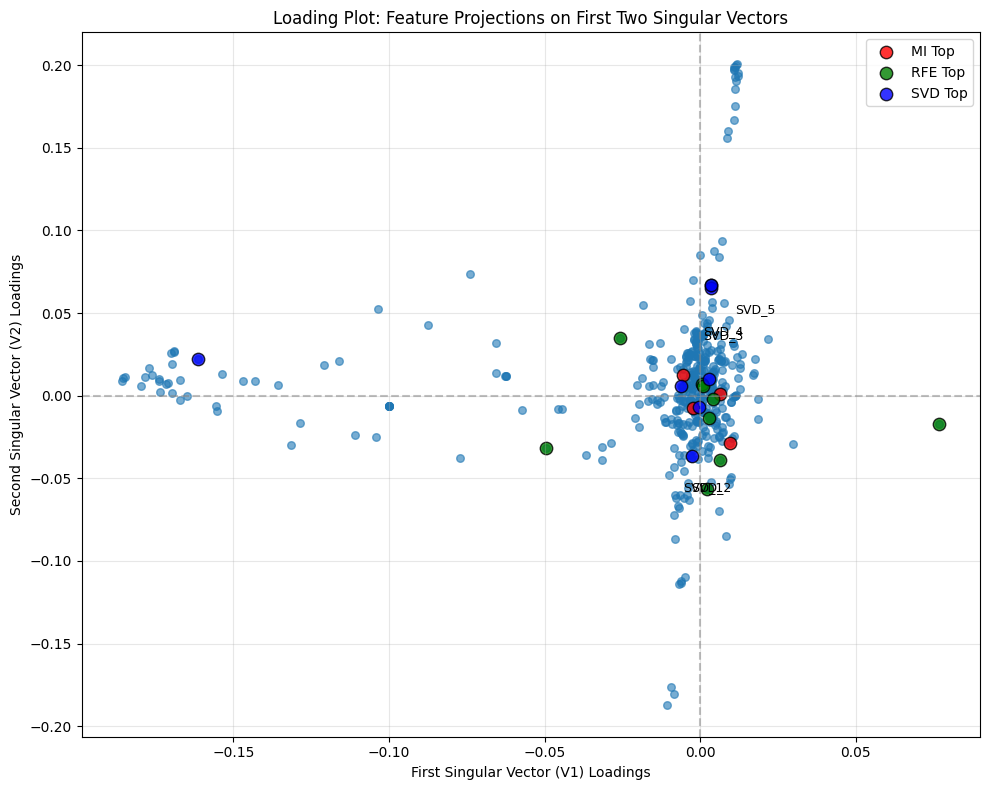

Loading plot created.
Total features plotted: 474
V1 range: [-0.186, 0.077]
V2 range: [-0.187, 0.201]


In [24]:
import matplotlib.pyplot as plt

print("Creating loading plot...")

V_component1 = Vt[0, :]
V_component2 = Vt[1, :]

plt.figure(figsize=(10, 8))
plt.scatter(V_component1, V_component2, alpha=0.6, s=30)

colors = ['red', 'green', 'blue']
methods = [top_20_mi_features, top_20_rfe_features, top_20_svd_features_norm]
labels = ['MI Top', 'RFE Top', 'SVD Top']

for color, method_features, label in zip(colors, methods, labels):
    feature_indices = []
    for f in method_features[:10]:
        try:
            idx = int(f)
            if idx < len(V_component1):
                feature_indices.append(idx)
        except:
            continue
    
    if feature_indices:
        plt.scatter(V_component1[feature_indices], V_component2[feature_indices], 
                   color=color, alpha=0.8, s=80, label=label, edgecolors='black')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('First Singular Vector (V1) Loadings')
plt.ylabel('Second Singular Vector (V2) Loadings')
plt.title('Loading Plot: Feature Projections on First Two Singular Vectors')
plt.legend()
plt.grid(alpha=0.3)

for i in range(5):
    idx = top_20_svd_idx_norm[i]
    plt.annotate(f'SVD_{i+1}', (V_component1[idx], V_component2[idx]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("Loading plot created.")
print(f"Total features plotted: {len(V_component1)}")
print(f"V1 range: [{V_component1.min():.3f}, {V_component1.max():.3f}]")
print(f"V2 range: [{V_component2.min():.3f}, {V_component2.max():.3f}]")